In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm
from torchsummary import summary # for model summary

In [ ]:
# -----------------------------------
# --- 1. Setup & Hyperparameters  ---
# -----------------------------------

# Device configuration (force to use CPU)
device = torch.device("cpu")
print(f"Using device: {device}")

# Hyperparameters
BATCH_SIZE = 64
LEARNING_RATE = 0.001
NUM_EPOCHS = 10
SEED = 42
IMAGE_SIZE = 28 # MNIST images are 28x28


# Reproducibility
torch.manual_seed(SEED)
np.random.seed(SEED)


Using device: cpu


In [ ]:

# -----------------------------------
# --- 2. Data Loading & Preprocessing ---
# -----------------------------------

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(), # Convert to tensor, scales to [0, 1]
    transforms.Normalize((0.1307,), (0.3081,)) # Normalize to have zero mean and unit variance
])

In [ ]:
# Load the MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:01<00:00, 5.21MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 154kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.45MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.97MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
# Create Data Loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers = 2) #add num_workers for parallel data loading.
test_loader  = DataLoader(dataset=test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers = 2)

In [ ]:
# Check data and shapes
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(f"Input shape: {images.shape}, labels shape: {labels.shape}")

Input shape: torch.Size([64, 1, 28, 28]), labels shape: torch.Size([64])


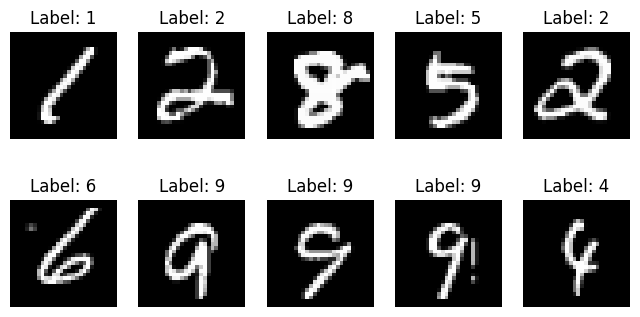

In [ ]:
# Visualize a few samples
plt.figure(figsize=(8, 4))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(images[i].squeeze().numpy(), cmap='gray')
    plt.title(f"Label: {labels[i]}")
    plt.axis('off')
plt.show()

In [ ]:
# -----------------------------------
# --- 3. CNN Model Definition  ---
# -----------------------------------
class CNN(nn.Module):
    def __init__(self,image_size):
        super(CNN, self).__init__()
        # Convolutional Layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1) # 1 input channel since MNIST is grayscale
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

        # MaxPooling Layer
        self.pool  = nn.MaxPool2d(kernel_size=2, stride=2)

        # Calculate the flattened input size of the fully connected layer.
        self.fc_input_size  = int((image_size/2/2) * (image_size/2/2) * 64) #divided by 2 twice for 2 max poolings

        # Fully connected Layers
        self.fc1 = nn.Linear(self.fc_input_size, 128)
        self.fc2 = nn.Linear(128, 10) # 10 output classes (0-9 digits)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # Pass the input through the layers
        x = self.pool(F.relu(self.conv1(x))) # Conv -> Relu -> MaxPool
        x = self.pool(F.relu(self.conv2(x))) # Conv -> Relu -> MaxPool

        x = x.view(x.size(0), -1)   # Flatten for FC Layers
        x = F.relu(self.fc1(x))     # FC -> Relu
        x = self.dropout(x)        #Dropout
        x = self.fc2(x)            # FC -> Output
        return x

In [ ]:
# Model instantiation and print summary
model = CNN(IMAGE_SIZE).to(device)
summary(model, (1, IMAGE_SIZE, IMAGE_SIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         MaxPool2d-2           [-1, 32, 14, 14]               0
            Conv2d-3           [-1, 64, 14, 14]          18,496
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Linear-5                  [-1, 128]         401,536
           Dropout-6                  [-1, 128]               0
            Linear-7                   [-1, 10]           1,290
Total params: 421,642
Trainable params: 421,642
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.36
Params size (MB): 1.61
Estimated Total Size (MB): 1.97
----------------------------------------------------------------


In [ ]:
# -----------------------------------
# --- 4. Loss Function & Optimizer ---
# -----------------------------------
# Define Loss (criterion) and Optimizer (SGD/Adam)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE) # or try SGD

In [ ]:
# -----------------------------------
# --- 5. Training Loop  ---
# -----------------------------------

print("Starting training...\n")

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []


for epoch in range(NUM_EPOCHS):
    model.train()  # Set model in training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    start_time = time.time()
    for batch_idx, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{NUM_EPOCHS}",leave=False):
        # images, labels = images.to(device), labels.to(device)  # No need to move to GPU

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train

    train_losses.append(epoch_loss)
    train_accuracies.append(train_accuracy)

    end_time = time.time()
    epoch_time = end_time - start_time


    # -----------------
    # --- Evaluation on test set
    # -----------------
    model.eval()  # Set model in evaluation mode
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad():  # disable gradients for evaluation
       for images, labels in test_loader:
           # images, labels = images.to(device), labels.to(device) # No need to move to GPU
           outputs = model(images)
           loss = criterion(outputs, labels)
           test_loss += loss.item()
           _, predicted = torch.max(outputs.data, 1)
           total_test += labels.size(0)
           correct_test += (predicted == labels).sum().item()

    test_loss = test_loss / len(test_loader)
    test_accuracy = 100 * correct_test / total_test
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print(f"\tEpoch: {epoch + 1}/{NUM_EPOCHS} | Train Loss: {epoch_loss:.4f} | Train Acc: {train_accuracy:.2f}% | Test Loss: {test_loss:.4f} | Test Acc: {test_accuracy:.2f}% | Time: {epoch_time:.2f}s")

print("\nFinished training!")

Starting training...



	Epoch: 1/10 | Train Loss: 0.0117 | Train Acc: 99.62% | Test Loss: 0.0343 | Test Acc: 99.11% | Time: 93.47s


	Epoch: 2/10 | Train Loss: 0.0104 | Train Acc: 99.61% | Test Loss: 0.0314 | Test Acc: 99.33% | Time: 96.31s


	Epoch: 3/10 | Train Loss: 0.0094 | Train Acc: 99.69% | Test Loss: 0.0336 | Test Acc: 99.15% | Time: 93.07s


	Epoch: 4/10 | Train Loss: 0.0080 | Train Acc: 99.74% | Test Loss: 0.0339 | Test Acc: 99.15% | Time: 96.15s


	Epoch: 5/10 | Train Loss: 0.0085 | Train Acc: 99.71% | Test Loss: 0.0349 | Test Acc: 99.28% | Time: 93.51s


	Epoch: 6/10 | Train Loss: 0.0070 | Train Acc: 99.78% | Test Loss: 0.0309 | Test Acc: 99.32% | Time: 96.09s


	Epoch: 7/10 | Train Loss: 0.0089 | Train Acc: 99.71% | Test Loss: 0.0352 | Test Acc: 99.25% | Time: 95.16s


	Epoch: 8/10 | Train Loss: 0.0063 | Train Acc: 99.78% | Test Loss: 0.0358 | Test Acc: 99.27% | Time: 94.60s


	Epoch: 9/10 | Train Loss: 0.0076 | Train Acc: 99.73% | Test Loss: 0.0361 | Test Acc: 99.19% | Time: 96.34s


	Epoch: 10/10 | Train Loss: 0.0054 | Train Acc: 99.80% | Test Loss: 0.0384 | Test Acc: 99.28% | Time: 93.07s

Finished training!


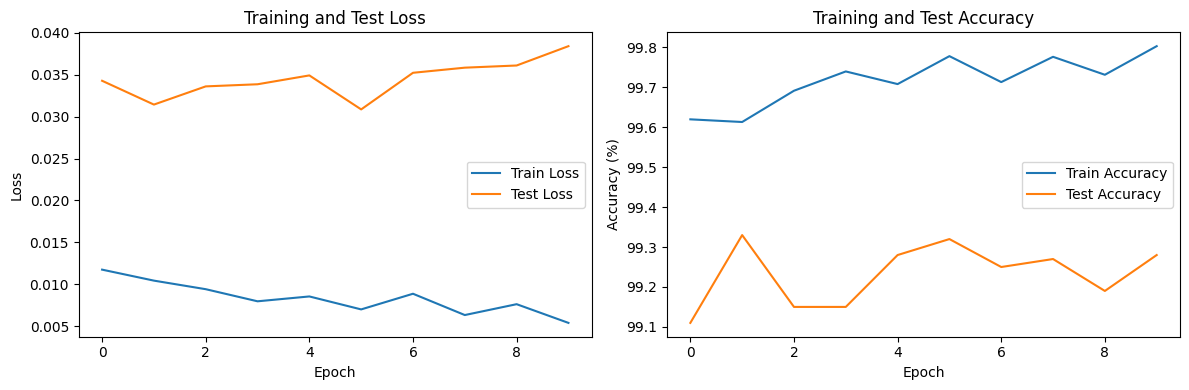

In [ ]:
# -----------------------------------
# --- 6. Plotting  ---
# -----------------------------------

# Plot training/test loss and accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label = "Test Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
from google.colab import files
from PIL import Image

# Upload an image
uploaded = files.upload()
filename = list(uploaded.keys())[0]  # Get the filename of the uploaded image


Saving images.png to images.png


In [ ]:
def preprocess_image(image_path):
    # Open the image
    image = Image.open(image_path).convert('L')  # Convert to grayscale

    # Resize the image to 28x28
    image = image.resize((28, 28))

    # Convert to a tensor and normalize
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))  # Normalize using the same stats as training
    ])
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    return image_tensor


In [ ]:
def predict_image(model, image_tensor):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation
        output = model(image_tensor)
        _, predicted_label = torch.max(output, 1)
    return predicted_label.item()


The predicted digit is: 3


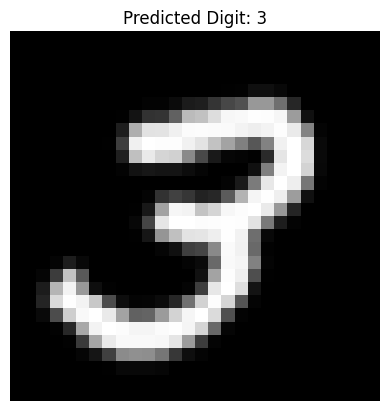

In [ ]:
# Preprocess the uploaded image
image_tensor = preprocess_image(filename)

# Predict the digit
predicted_digit = predict_image(model, image_tensor)

# Display the result
print(f"The predicted digit is: {predicted_digit}")

# Optionally, show the image
plt.imshow(image_tensor.squeeze().numpy(), cmap='gray')
plt.title(f"Predicted Digit: {predicted_digit}")
plt.axis('off')
plt.show()
